In [1]:
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv

--2025-10-21 13:22:35--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 80876 (79K) [text/plain]
Saving to: 'course_lead_scoring.csv.2'

     0K .......... .......... .......... .......... .......... 63% 11.7M 0s
    50K .......... .......... ........                        100% 21.6M=0.005s

2025-10-21 13:22:35 (14.1 MB/s) - 'course_lead_scoring.csv.2' saved [80876/80876]



In [2]:
import pandas as pd
import numpy as np

In [3]:
df = pd.read_csv('course_lead_scoring.csv.2')


In [4]:
categorical_columns = ["lead_source","industry","employment_status","location"]
numerical_columns = ["number_of_courses_viewed","annual_income","interaction_count","lead_score","converted"]

In [5]:
for i in categorical_columns:
    print(df[i].isnull().sum())
df[categorical_columns] = df[categorical_columns].fillna("NA")


128
134
100
63


In [6]:
for i in numerical_columns:
    print(df[i].isnull().sum())
df[numerical_columns] = df[numerical_columns].fillna(0.0)

0
181
0
0
0


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score


In [9]:
target = 'converted'  
y = df[target]                   
X = df.drop(columns=[target])    


In [10]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, random_state=1
)

# Then split the temp set equally into validation (20%) and test (20%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=1
)

In [22]:
numerical_columns_no_target = ["number_of_courses_viewed","annual_income","interaction_count","lead_score"]
for i in numerical_columns_no_target:
    auc = roc_auc_score(y_train,X_train[i])
    print(f"AUC for {i}: {auc}")




AUC for number_of_courses_viewed: 0.7652439024390244
AUC for annual_income: 0.5446354552990968
AUC for interaction_count: 0.7271914132379249
AUC for lead_score: 0.6111168681007025


In [27]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

train_dicts = X_train.to_dict(orient='records')
val_dicts = X_val.to_dict(orient='records')

dv = DictVectorizer(sparse=False)

X_train_encoded = dv.fit_transform(train_dicts)
X_val_encoded = dv.transform(val_dicts)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train_encoded, y_train)

y_pred = model.predict_proba(X_val_encoded)[:, 1]

auc = roc_auc_score(y_val, y_pred)
print("AUC on validation dataset:", auc)


AUC on validation dataset: 0.7944791666666666


In [28]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score

C:\Users\fulbe\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\fulbe\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


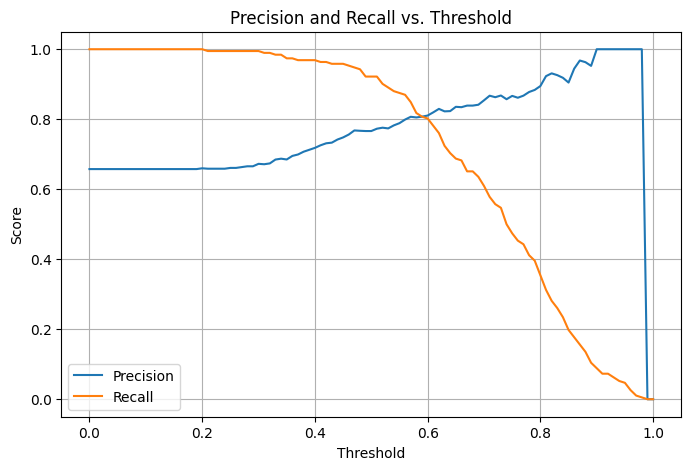

In [30]:
thresholds = np.arange(0.0, 1.01, 0.01)

precisions = []
recalls = []
for t in thresholds:
    y_pred_class = (y_pred >= t).astype(int)
    precisions.append(precision_score(y_val, y_pred_class))
    recalls.append(recall_score(y_val, y_pred_class))

plt.figure(figsize=(8, 5))
plt.plot(thresholds, precisions, label="Precision")
plt.plot(thresholds, recalls, label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision and Recall vs. Threshold")
plt.legend()
plt.grid(True)
plt.show()

In [31]:
idx = np.argmin(np.abs(np.array(precisions) - np.array(recalls)))
intersection_threshold = thresholds[idx]
print(f"Precision and recall intersect at threshold ≈ {intersection_threshold:.2f}")

Precision and recall intersect at threshold ≈ 0.59


In [32]:
thresholds = np.arange(0.0, 1.01, 0.01)

f1_scores = []

for t in thresholds:
    y_pred_class = (y_pred >= t).astype(int)
    P = precision_score(y_val, y_pred_class)
    R = recall_score(y_val, y_pred_class)
    
    # Compute F1 using the given formula
    if P + R == 0:
        f1 = 0
    else:
        f1 = 2 * P * R / (P + R)
    f1_scores.append(f1)

# Find the best threshold
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"Best F1 = {best_f1:.3f} at threshold = {best_threshold:.2f}")

Best F1 = 0.848 at threshold = 0.47


C:\Users\fulbe\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\fulbe\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [33]:
from sklearn.model_selection import KFold

In [36]:

kfold = KFold(n_splits=5, shuffle=True, random_state=1)
scores = []
df_full_train = X.copy()
df_full_train['converted'] = y
for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val   = df_full_train.iloc[val_idx]
    
    # Split features and target
    X_train = df_train.drop(columns=['converted'])
    y_train = df_train['converted'].values
    X_val   = df_val.drop(columns=['converted'])
    y_val   = df_val['converted'].values
    
    # One-hot encode
    dv = DictVectorizer(sparse=False)
    X_train_enc = dv.fit_transform(X_train.to_dict(orient='records'))
    X_val_enc   = dv.transform(X_val.to_dict(orient='records'))
    
    # Train logistic regression
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train_enc, y_train)
    
    # Predict probabilities and compute AUC
    y_pred = model.predict_proba(X_val_enc)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print("AUCs:", [round(s, 3) for s in scores])
print("Mean AUC:", round(np.mean(scores), 3))
print("Std dev:", round(np.std(scores), 3))


AUCs: [np.float64(0.817), np.float64(0.779), np.float64(0.831), np.float64(0.868), np.float64(0.809)]
Mean AUC: 0.821
Std dev: 0.029


In [37]:
C_values = [0.000001, 0.001, 1]
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for C in C_values:
    auc_scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val   = df_full_train.iloc[val_idx]

        X_train = df_train.drop(columns=['converted'])
        y_train = df_train['converted']
        X_val   = df_val.drop(columns=['converted'])
        y_val   = df_val['converted']

        dv = DictVectorizer(sparse=False)
        X_train_enc = dv.fit_transform(X_train.to_dict(orient='records'))
        X_val_enc   = dv.transform(X_val.to_dict(orient='records'))

        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_train_enc, y_train)
        y_pred = model.predict_proba(X_val_enc)[:, 1]

        auc = roc_auc_score(y_val, y_pred)
        auc_scores.append(auc)

    print(f"C={C}")
    print("Mean AUC:", round(np.mean(auc_scores), 3))
    print("Std AUC:", round(np.std(auc_scores), 3))
    print()


C=1e-06
Mean AUC: 0.549
Std AUC: 0.03

C=0.001
Mean AUC: 0.862
Std AUC: 0.024

C=1
Mean AUC: 0.821
Std AUC: 0.029

